In [70]:
from cd_poly import *

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

np.random.seed(0)

In [71]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [72]:
from cd_poly import *

## Gaussian example

In [30]:
mu = np.zeros(2)
sig = np.array([[1., .5,], [.5, 1.]])

z = multivariate_normal(mu, sig).rvs(100)

In [31]:
p = CDPolynomial(z, degree=3)

In [32]:
p(np.array([[1., 1.], [2.,  2.], [3., 3.]]))

array([  4.72098249,  58.01005246, 632.83761363])

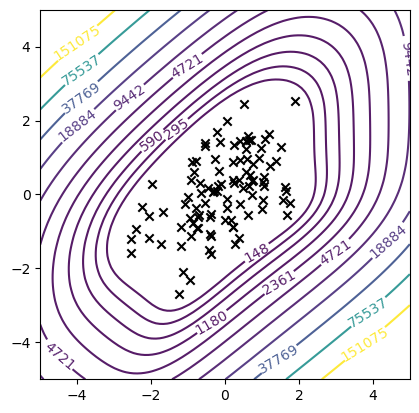

In [33]:
min_level = p(z).max().item()
levels = [min_level * 2 ** i for i in range(1, 12)]

fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plot_contours(p, ax, levels=levels)
ax.scatter(*z.T, color='black', marker='x')
ax.set_aspect('equal')

In [34]:
sample_vals = p(z)
sample_vals.mean(), p.n_monomials # these should be almost equal, according to Lemma 3

(np.float64(10.000000000000014), 10)

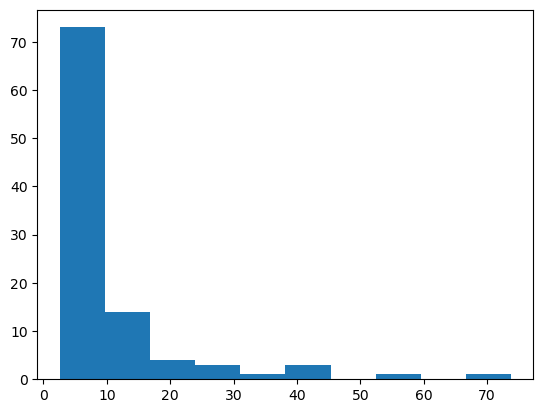

In [35]:
plt.hist(sample_vals);

In [36]:
idx_max = np.argmax(sample_vals)
print(f'Sample point with most extreme CD poly value: {z[idx_max]}')

Sample point with most extreme CD poly value: [1.88414474 2.53776333]


In [37]:
quantiles = [np.quantile(sample_vals, q=q) for q in [0., .25, .5, .75, 1.]]
quantiles

[np.float64(2.6083465968446915),
 np.float64(4.03112280621807),
 np.float64(5.585704359967584),
 np.float64(10.059331140479998),
 np.float64(73.76691959796487)]

## Number of samples vs. total degree

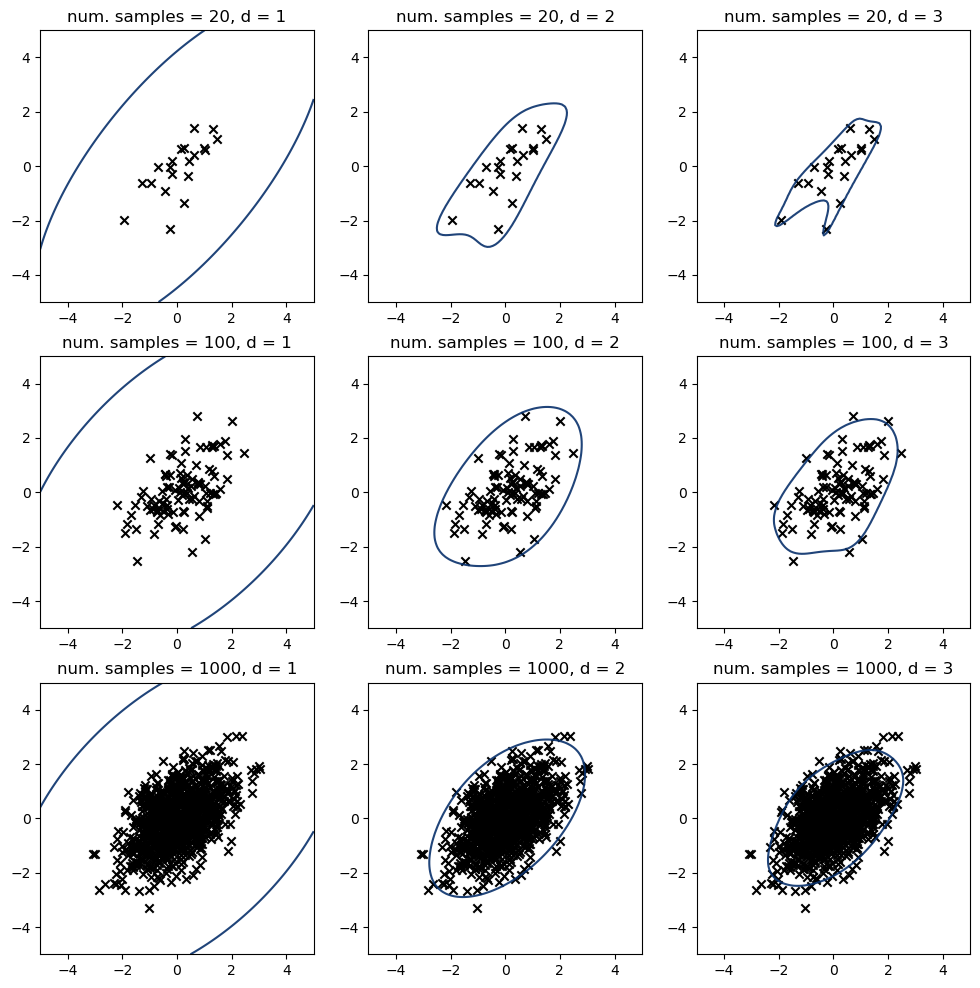

In [38]:
lim = 5
ns = [20, 100, 1_000]
ds = [1, 2, 3]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    z = multivariate_normal([0., 0.], [[1., .5], [.5, 1.]]).rvs(ns[i])
    for j in range(3):
        p = CDPolynomial(z, degree=ds[j])
        ax = axs[i, j]
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        plot_level_set(p, 40., ax)
        ax.scatter(*z.T, color='black', marker='x')
        ax.set_title(f'num. samples = {ns[i]}, d = {ds[j]}')

## Degree vs. Cutoff hyperparam

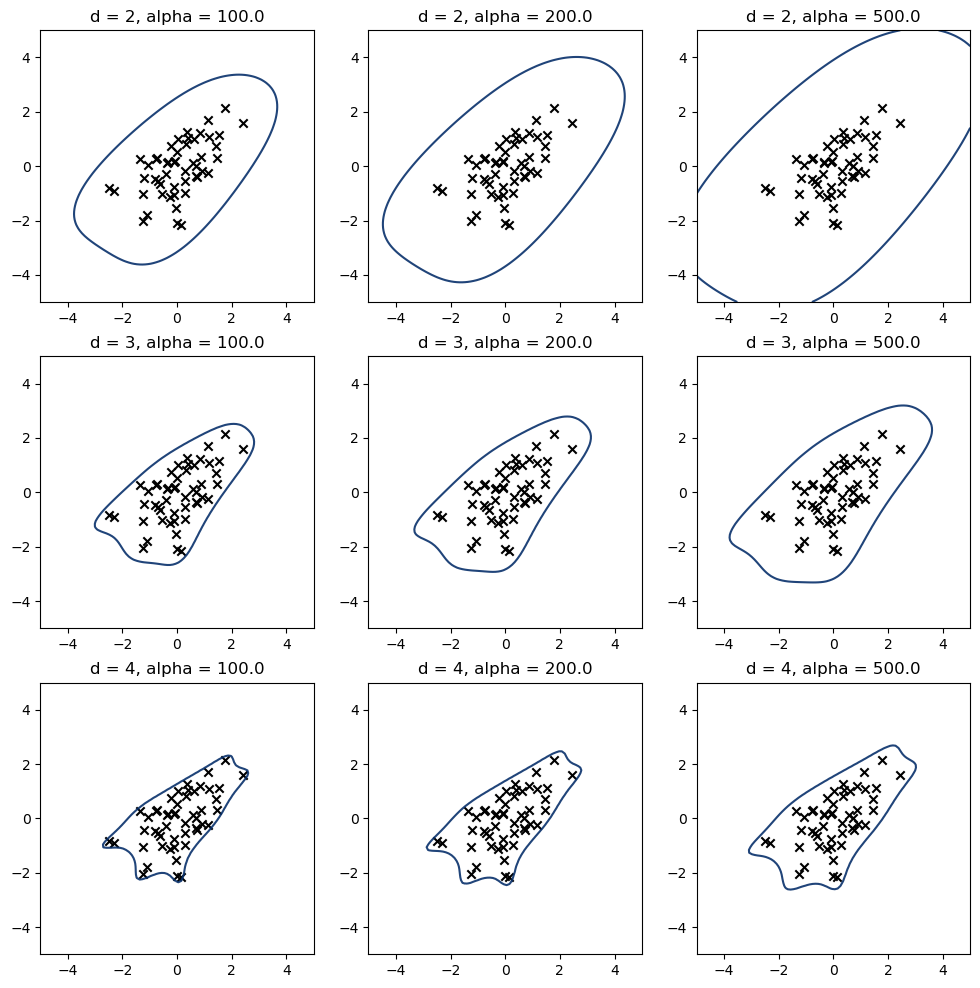

In [39]:
lim = 5
ds = [2, 3, 4]
cuts = [100., 200., 500.]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

z = multivariate_normal([0., 0.], [[1., .5], [.5, 1.]]).rvs(50)
for i in range(3):
    for j in range(3):
        p = CDPolynomial(z, degree=ds[i])
        ax = axs[i, j]
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        plot_level_set(p, cuts[j], ax)
        ax.scatter(*z.T, color='black', marker='x')
        ax.set_title(f'd = {ds[i]}, alpha = {cuts[j]}')

## Extending to the infinite-dimensional case: Chebyshev basis

In [40]:
from scipy.special import eval_chebyt

class Chebyshev():
    """
    A function represented by coordinates in the Chebyshev basis.
    """

    def __init__(self, coords):
        self.n_basis = len(coords)
        self.coords = coords

    def __call__(self, z):
        """
        Evaluate the function represented by these coordinates at z. Vectorized over z.
        """
        proj = np.column_stack([eval_chebyt(k, z) for k in range(self.n_basis)])
        return  proj @ self.coords
    
    def __add__(self, other):
        return Chebyshev(self.coords + other.coords)

In [41]:
const = 1 / 3
g0 = Chebyshev(np.array([0., const, const, const])) # reference function

In [42]:
def sample_funcs(n_funcs, noise=.1):
    "Sample functions on [-1, 1] using the Chebyshev basis."
    coords = sample_ball_unif(n_funcs, noise, dim=4)
    funcs = [g0 + Chebyshev(coord) for coord in coords]
    return funcs

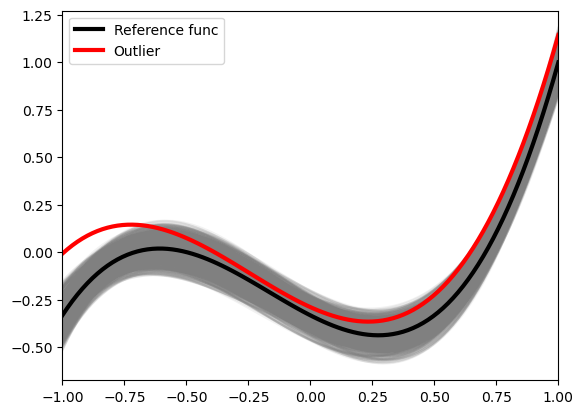

In [43]:
fig, ax = plt.subplots()

gs = sample_funcs(1_000)
for g in gs:
    plot_func(g, ax, color='grey', alpha=.1)

plot_func(g0, ax, label='Reference func', lw=3, color='black')

g_outlier = sample_funcs(1, noise=.2)[0]
plot_func(g_outlier, ax, label='Outlier', lw=3, color='red')

ax.set_xlim(-1, 1)
ax.legend()

In [44]:
gs_coords = np.stack([g.coords for g in gs])

p = CDPolynomial(gs_coords, degree=4, eps=0.)

In [45]:
p.alg_deg, p.harm_deg, p.n_monomials

(4, 4, 70)

In [46]:
sample_vals = p(gs_coords)

sample_vals.max()

np.float64(214.50405658523232)

In [47]:
# should be about equal, according to Lemma 3
# this will only be the case if the regularization param eps is set to zero
sample_vals.mean(), p.n_monomials 

(np.float64(70.00003968392986), 70)

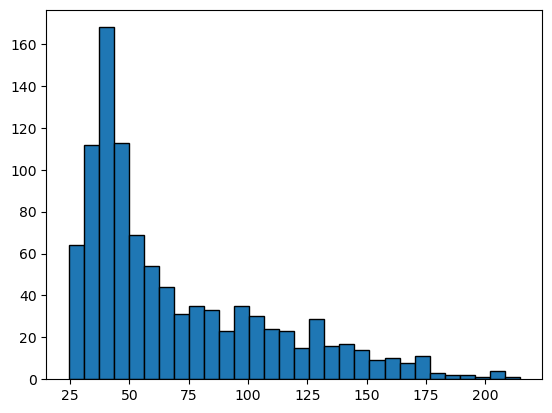

In [48]:
plt.hist(sample_vals, bins=30, edgecolor='black', lw=.5);

In [49]:
p(np.array([g_outlier.coords])) # as expected, much larger than for the sampled functions

array([86203.63052423])

## Gaussian mixture example

In [73]:
n = 1000

mu1 = np.array([-2., 0])
sig1 = np.array([[.2, .0,], [.0, 4.]])
z1 = multivariate_normal(mu1, sig1).rvs(n // 2)

mu2 = np.array([2., 0])
sig2 = np.array([[4., .0,], [.0, .2]])
z2 = multivariate_normal(mu2, sig2).rvs(n // 2)

z = np.concatenate([z1, z2])

In [74]:
p = CDPolynomial(z, degree=4)

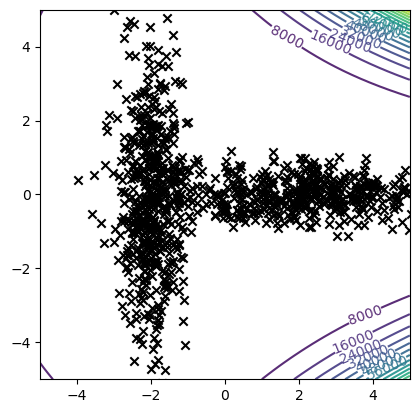

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plot_contours(p, ax, levels=20)
ax.scatter(*z.T, color='black', marker='x')
ax.set_aspect('equal')

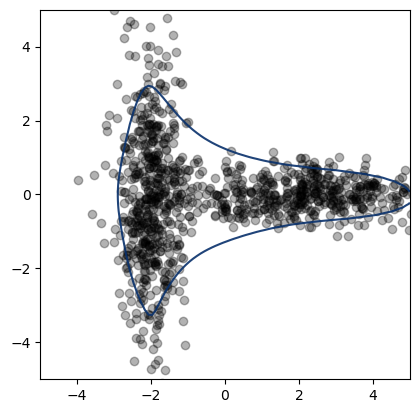

In [85]:
cutoff = p(z).max().item()
fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plot_level_set(p, 15, ax)
ax.scatter(*z.T, color='black', alpha=.3)
ax.set_aspect('equal')